Try random forests, start with an example of the iris data set

In [3]:
import splat
import sklearn
import wisps
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from wisps import Annotator
import math

In [5]:
from sklearn.metrics import accuracy_score

In [6]:
from wisps import datasets

In [7]:
spdf=datasets['spex_data_set']

In [8]:
hst3d=datasets['aegis_cosmos']

Label the spex data by spectral type

In [9]:
hst3d.columns, spdf.columns

(Index(['CH_4/H-Cont', 'CH_4/H_2O-1', 'CH_4/H_2O-2', 'CH_4/J-Cont',
        'H-cont/H_2O-1', 'H-cont/H_2O-2', 'H-cont/J-Cont', 'H_2O-1/J-Cont',
        'H_2O-2/H_2O-1', 'H_2O-2/J-Cont', 'name', 'line_chi', 'spex_chi',
        't_snr', 'f_test'],
       dtype='object'),
 Index(['CH_4/H-Cont', 'CH_4/H_2O-1', 'CH_4/H_2O-2', 'CH_4/J-Cont',
        'H-cont/H_2O-1', 'H-cont/H_2O-2', 'H-cont/J-Cont', 'H_2O-1/J-Cont',
        'H_2O-2/H_2O-1', 'H_2O-2/J-Cont', 'spt', 'spex_chi', 'name', 'l_snr',
        'l_t_snr', 'med_snr', 'cdf_snr', 'line_chi', 'f_x'],
       dtype='object'))

In [10]:
#make the features numeric 
spdf=Annotator.reformat_table(Annotator.group_by_spt(spdf,assign_from_one=True, spt_label='spt').drop('data_type', axis=1).replace(np.inf, np.nan)).dropna(how='any')

In [11]:
#columns to care about 
columns=wisps.INDEX_NAMES

In [12]:
sptrain=spdf[columns]
splabels=spdf['spt_range']

In [13]:
#sptrain
sp_train=sptrain[:762]
sp_test=sptrain[762:]
sp_train_labels=splabels[:762].values
sp_test_labels=splabels[762:].values

In [14]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=1000, oob_score=True, random_state=123456)
rf.fit(sp_train, sp_train_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=True, random_state=123456, verbose=0,
            warm_start=False)

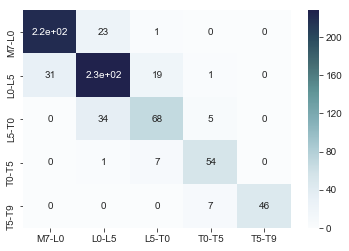

In [15]:
from sklearn.metrics import confusion_matrix
spex_predicted = rf.predict(sp_test)
model_accuracy = accuracy_score(sp_test_labels, spex_predicted)
    #y_test, predicted
classes=['M7-L0', 'L0-L5', 'L5-T0','T0-T5','T5-T9']
cm = pd.DataFrame(confusion_matrix(sp_test_labels, spex_predicted), 
                  columns=classes, index=classes)
sns.heatmap(cm, annot=True, cmap=wisps.MYCOLORMAP)

In [16]:
print (model_accuracy)

0.8270777479892761


This works in principle, almost as good as my boxes

In [17]:
#pred sets

#look at things with f(x)>0.8
new_cols=np.append(columns, 'name')
fmtted=Annotator.reformat_table(hst3d[(hst3d.f_test>0.8)&(hst3d.t_snr>5.0)][new_cols]).replace(np.inf, np.nan).dropna(how='any')
pred_set=fmtted[columns].values

In [18]:
pred_set.shape

(77, 10)

In [19]:
#fmtted.reindex()

In [20]:
#test_set
from sklearn import preprocessing
set_pred_labels=rf.predict(pred_set)

Text(0, 0.5, 'number')

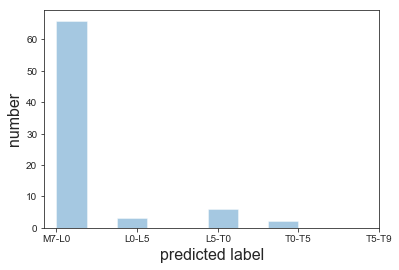

In [21]:
fig, ax=plt.subplots()
sns.distplot(set_pred_labels, kde=False, ax=ax)
ax.set_xticks([1.0, 2.0, 3.0, 4.0, 5.0])
ax.set_xticklabels(['M7-L0', 'L0-L5', 'L5-T0','T0-T5','T5-T9'])
ax.set_xlabel('predicted label', fontsize=16)
ax.set_ylabel('number', fontsize=16)

In [22]:
slct=fmtted.iloc[np.where(set_pred_labels>1.0)[0]]


In [23]:
slct

,H_2O-1/J-Cont,H_2O-2/H_2O-1,H-cont/H_2O-1,CH_4/H_2O-1,H_2O-2/J-Cont,H-cont/J-Cont,CH_4/J-Cont,H-cont/H_2O-2,CH_4/H_2O-2,CH_4/H-Cont,name
11,0.336757,0.394236,1.543710,0.719384,0.132762,0.519855,0.242257,3.915696,1.824752,0.466010,aegis-03-G141_17053.1D.ascii
19,0.980167,0.243498,0.952332,0.695074,0.238668,0.933444,0.681289,3.911054,2.854544,0.729866,aegis-05-G141_27802.1D.ascii
20,0.894074,0.553001,1.066769,0.666109,0.494424,0.953770,0.595551,1.929055,1.204536,0.624418,aegis-05-G141_28082.1D.ascii
24,131.379706,0.035964,1.069082,1.045468,4.724934,140.455656,137.353299,29.726478,29.069886,0.977912,aegis-06-G141_06975.1D.ascii
91,1.020519,0.761336,6.401986,5.076741,0.776957,6.533348,5.180910,8.408888,6.668203,0.792995,cosmos-08-G141_24608.1D.ascii
94,1.264839,0.126592,1.002627,1.003331,0.160119,1.268162,1.269052,7.920121,7.925682,1.000702,cosmos-08-G141_27262.1D.ascii
106,1.000000,0.220521,1.000000,1.000000,0.220521,1.000000,1.000000,4.534725,4.534725,1.000000,cosmos-11-G141_28568.1D.ascii
125,1.024732,0.463484,0.930037,0.805721,0.474947,0.953039,0.825648,2.006622,1.738400,0.866332,cosmos-18-G141_17314.1D.ascii
126,1.095927,0.180236,0.984817,0.980301,0.197525,1.079287,1.074338,5.464050,5.438997,0.995415,cosmos-18-G141_18833.1D.ascii
160,1.454404,0.264447,0.512219,1.141213,0.384613,0.744974,1.659784,1.936942,4.315462,2.227977,cosmos-25-G141_19146.1D.ascii


In [24]:
def plot_spec(n):
        sp=wisps.Spectrum(name=n)
        sp.plot()

def plot(n):
    try:
        sp=wisps.Source(name=n)
        print (sp.flags, sp.spectral_type)
        if ((sp.flags[-3] ==1.0)& (sp.flags[-1]<0.1) & (sp.flags[-2]<0.1)): sp.plot()
    except KeyError: pass

In [26]:
slct.name

11      aegis-03-G141_17053.1D.ascii
19      aegis-05-G141_27802.1D.ascii
20      aegis-05-G141_28082.1D.ascii
24      aegis-06-G141_06975.1D.ascii
91     cosmos-08-G141_24608.1D.ascii
94     cosmos-08-G141_27262.1D.ascii
106    cosmos-11-G141_28568.1D.ascii
125    cosmos-18-G141_17314.1D.ascii
126    cosmos-18-G141_18833.1D.ascii
160    cosmos-25-G141_19146.1D.ascii
164    cosmos-26-G141_12377.1D.ascii
Name: name, dtype: object